# Problem Set 4, due May 16 at 11:59am, mid-day, noon.

### Before You Start

This is a fun but challenging problem set. It will test your python skills, as well as your understanding of the material in class and in the readings. Start early and debug often! Some notes:

* Part 1 is meant to be easy, so get through it quickly.
* Part 2 (especially 2.1) will be difficult, but it is the lynchpin of this problem set to make sure to do it well and understand what you've done. If you find your gradient descent algorithm is taking more than a few minutes to complete, debug more, compare notes with others, and go to the TA sessions.
* Depending on how well you've done 2.1, parts 2.3 and 3.3 will be relatively painless or incredibly painful. 
* Part 3 (especially 3.3) will be computationally intensive. Don't leave this until the last minute, otherwise your code might be running when the deadline arrives.
* Do the extra credit problems last.

---

## Introduction to the assignment

As with the last assignment, you will be using the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing).

In [1]:
from __future__ import division
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

from sklearn.datasets import load_boston
from sklearn import linear_model


bdata = load_boston()
boston = pd.DataFrame(bdata.data)

boston.columns = bdata.feature_names[:]
boston['MEDV'] = bdata.target

---

## Part 1: Getting oriented

Use different learning rates

### 1.1 Use existing libraries

Soon, you will write your own gradient descent algorithm, which you will then use to minimize the squared error cost function.  First, however, let's use the canned versions that come with Python, to make sure we understand what we're aiming to achieve.

Using the same Boston housing prices dataset, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to explore the relationship between  median housing price and number of rooms per house. Do this by first (a) regressing the housing price on the number of rooms per house, and then (b) regressing the housing price on the number of rooms per house and the (number of rooms per house) squared.  **Interpret your results.**

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn import linear_model
 

x = boston.RM[:, np.newaxis]
y = bdata.target[:, np.newaxis]

regr = linear_model.LinearRegression()
regr = regr.fit(x,y)
print 'Intercept: ' + str(regr.intercept_)
print 'coef: ' + str(regr.coef_)

firstInter = regr.intercept_
firstCoef = regr.coef_ 

xsq = [x,x**2]
data = pd.DataFrame()
data['x'] = boston.RM

data['x2'] = (boston.RM ** 2)
newReg = linear_model.LinearRegression()
newReg = newReg.fit(data,y)

print 'Intercept: ' + str(newReg.intercept_)
print 'Coef: '+ str(newReg.coef_)

coef2 = newReg.coef_
inter2 = newReg.intercept_

Intercept: [-34.67062078]
coef: [[ 9.10210898]]
Intercept: [ 66.05884748]
Coef: [[-22.64326237   2.47012384]]


Intercept is -34 and slope is 9.1 so for everyroom the price of the house goes up by 9 thousond.

### 1.2 Training and testing

Chances are, for the above problem you used all of your data to fit the regression line. In some circumstances this is a reasonable thing to do, but often this will result in overfitting. Let's redo the above results the ML way, using careful cross-validation.  Since you are now experts in cross-validation, and have written your own cross-validation algorithm from scratch, you can now take a shortcut and use the libraries that others have built for you.

Using the [cross-validation functions](http://scikit-learn.org/stable/modules/cross_validation.html) from scikit-learn, use k-fold cross-validation to fit regression (a) above, i.e. the linear fit of housing price on number of rooms per house. Each fold of cross-validation will give you one slope coefficient and one intercept coefficient.  Plot the distribution of the k slope coefficients, and draw a vertical line at the value of the slope coefficient that you estimated in 1.1 using the full dataset.  What do you observe?

In [3]:
%matplotlib inline 
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
train, test = train_test_split(boston['MEDV'], test_size=0.34, random_state=4973)

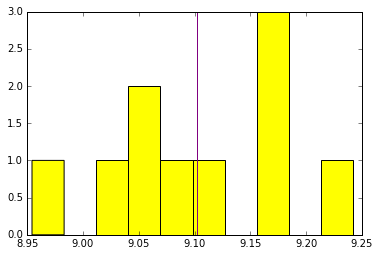

In [91]:
kf = cross_validation.KFold(len(boston), n_folds=10, shuffle=True, random_state=4)
coef = []
reg = linear_model.LinearRegression()
for train, test in kf:
    train = boston.loc[train]
    data = pd.DataFrame()
    data['x'] = train['RM']
    reg = reg.fit(data,train.MEDV)
    coef.append(reg.coef_[0]) 
    
# Plot outputs
plt.hist(coef,color = 'yellow')
plt.axvline(firstCoef ,color = 'purple')
plt.show()

It looks like the mjority of houses have 3 rooms and for every room the house goes up in price by 9 thousond

### 1.3 Regression lines

Create a scatterplot of housing price on rooms per house, and add the two regression lines from 1.1 (or 1.2 if you prefer to do so). Show the linear regression line in red, and the linear+quadratic regression line (which may have curvature) in blue.  Label these two regression lines with the corresponding regression equations (i.e. the slope and intercept of the line).

Bonus: Add the 95% confidence bands (i.e.,  the area that has a 95% chance of containing the true regression line) to each of these lines.

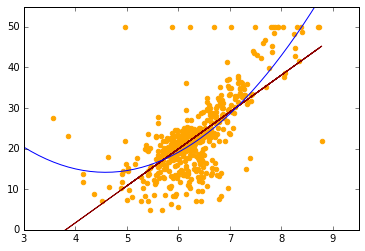

In [5]:
plt.scatter(boston['RM'],boston['MEDV'],color = 'orange')
plt.plot(x,regr.predict(x), color = 'darkred')
coefs = coef2[0][0]
coefs2 = coef2[0][1]
plt.plot(np.linspace(3,10,50), coefs * np.linspace(3,10,50) + coefs2 * np.linspace(3,10,50) ** 2 + inter2 , color = 'blue')
axes = plt.gca()
axes.set_xlim(3,9.5)
axes.set_ylim(0,55)

plt.show()

## Part 2: Gradient descent: Linear Regression

This is where it gets fun!

### 2.1 Implement gradient descent with one independent variable (Average rooms per house)

Implement the basic gradient descent algorithm that we discussed in class. Use the version you implement to regress the housing price on the number of rooms per house. Experiment with 3-4 different values of the learning rate *R*, and do the following:

* Report the values of alpha and beta that minimize the loss function
* Report the number of iterations it takes for your algorithm to converge (for each value of *R*)
* Report the total running time of your algorithm, in seconds

Some skeleton code is provided below, but you should feel free to delete this code and start from scratch if you prefer.

* *Hint 1: Don't forget to implement a stopping condition, so that at every iteration you check whether your results have converged. Common approaches to this are to (a) check to see if the loss has stopped decreasing; and (b) check if both your current parameter esimates are close to the estimates from the previous iteration.  In both cases, "close" should not be ==0, it should be <=epsilon, where epsilon is something very small (like 0.0001).*
* *Hint 2: Some people like to include a MaxIterations parameter in their gradient descent algorithm, to prevent divergence. *
* *Hint 3: R = 0.005 is a reasonable first guess - but try some others to see how it affects your results. *

In [93]:
import time

"""
Function
--------
bivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalues, yvalues : narray
    xvalues: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta: float
    co-efficient
"""
#def calc_cost()

def bivariate_ols(xvalues, yvalues, R=0.01, MaxIterations=1000, tol=0.005, alpha=0.0, beta=0.0):    

    start_time = time.time()

    # initialize the parameters

    alphaCurr = alpha
    betaCurr = beta
    
    for i in range(0,MaxIterations):
        alpha = alphaCurr
        beta = betaCurr
        alphaCurr = alpha - (R/len(xvalues))*sum(alpha+np.dot(beta, xvalues) - yvalues)
        betaCurr = beta - (R/len(xvalues))*np.dot((alpha+np.dot(beta, xvalues) - yvalues), xvalues)
        
        aDiff = abs(alphaCurr - alpha)
        bDiff = abs(betaCurr - beta)
        
#         costCurr = 1/(2.0*len(xvalues)) + sum((alphaCurr + np.dot(betaCurr, xvalues) - yvalues)**2)
#         costPrev = 1/(2.0*len(xvalues)) + sum((alpha + np.dot(beta, xvalues) - yvalues)**2)
         
#         if costCurr > costPrev:
#             print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
#             print "Diverging"
#             print i
#             return alphaCurr, betaCurr
        if aDiff <=tol and bDiff <= tol:
            print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
            print 'tolerance met'
            print i
            return alphaCurr, betaCurr
        
    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    print 'Max Iter: '
    print MaxIterations
    return alphaCurr, betaCurr

# example function call
print bivariate_ols(xvalues=boston['RM'], yvalues=boston['MEDV'], MaxIterations=70000,R=0.01,tol=.0001)
print bivariate_ols(xvalues=boston['RM'], yvalues=boston['MEDV'], MaxIterations=70000, R=0.001, tol=.0001)
print bivariate_ols(xvalues=boston['RM'], yvalues=boston['MEDV'], MaxIterations=70000, R=0.005, tol=.0001)

Time taken: 9.36 seconds
tolerance met
31156
(-33.839101219068688, 8.9713898912177363)
Time taken: 20.55 seconds
Max Iter: 
70000
(-19.486291192117807, 6.7150553907242578)
Time taken: 14.78 seconds
tolerance met
50783
(-33.007336218346211, 8.8406322163158144)


*Enter your observations here*

### 2.2 Data normalization

Soon, you will implement a version of gradient descent that can use an arbitrary number of independent variables. Before doing this, however, you should re-scale your features to ensure that no single feature dominates the cost function. Write a simple function to [standardize](http://en.wikipedia.org/wiki/Standard_score) a feature. * This is done for you!*

In [7]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

features = pd.DataFrame()
features['CRIM'] = standardize(boston.CRIM)
features['RM'] = standardize(boston.RM)
features['MEDV'] = boston['MEDV']
print bivariate_ols(xvalues=features['RM'], yvalues=boston['MEDV'], MaxIterations=1000, tol=.0001)

Time taken: 0.24 seconds
tolerance met
769
(22.522990763165684, 6.3861921075099595)


### 2.3 Implement gradient descent with an arbitrary number of independent variables

Now that you have a simple version of gradient descent working, create a version of gradient descent that can take more than one independent variable.  Assume all independent variables will be continuous.  Test your algorithm using CRIM and RM as independent variables. Standardize these variables before before inputting them to the gradient descent algorithm. 

As before,  report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with 2-3 different values of R.

* *Hint 1: Be careful to implement this efficiently, otherwise it might take a long time for your code to run. Commands like `np.dot` can be a good friend to you on this problem - see 2.2 above for an example.*

In [8]:
"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta_array: array[float]
    co-efficient
"""

def multivariate_ols(xvalue_matrix, yvalues, R=0.001, MaxIterations=1000,tol = 0.001,alpha = 0.0, betas = None, prints = False):
    start_time = time.time()

    xvalue_matrix = xvalue_matrix.values
    yvalues = yvalues.values
    feat = xvalue_matrix.shape[1]
    
    alpha = 0
    beta = np.zeros(feat)
        
    for i in range(0,MaxIterations):
        alphaCurr = np.sum(alpha + xvalue_matrix.dot(beta) - yvalues) / len(yvalues)
        betaCurr = np.sum((alpha + xvalue_matrix.dot(beta) - yvalues) * xvalue_matrix.T, axis=1) / len(yvalues)
        
        alpha = alpha - (R * alphaCurr)
        beta = beta - (R * betaCurr)
        
        if abs(alphaCurr) <= tol and (np.abs(betaCurr) <= tol).all():
            if prints == True:
                print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
                print 'tollerance: '
                print i
            return alpha, beta
    if prints == True:
        print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
        print 'Max Iter: '
        print MaxIterations  
    return alpha, beta

xvalue_matrix = features[['RM', 'CRIM']]
print multivariate_ols(xvalue_matrix, yvalues=boston['MEDV'], R=0.001, MaxIterations=100000,tol = 0.001,prints=True)

Time taken: 0.32 seconds
tollerance: 
10018
(22.531807608542223, array([ 5.89366345, -2.24932263]))


*Enter your observations here*

### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time do not standardize your variables - i.e., use the original data. Use the same three values of R (0.1, 0.01, and 0.001). What do you notice about the running time and convergence properties of your algorithm?

In [9]:
xvalue_matrix = boston[['RM','CRIM']]
print multivariate_ols(xvalue_matrix, yvalues=boston['MEDV'], R=0.1, MaxIterations=100000,tol = 0.001)
print multivariate_ols(xvalue_matrix, yvalues=boston['MEDV'], R=0.01, MaxIterations=100000,tol = 0.001)
print multivariate_ols(xvalue_matrix, yvalues=boston['MEDV'], R=0.001, MaxIterations=100000,tol = 0.001)

# The learning rate of .1 is too big and it diverges and gives nan values. However a learning rate of .01 gives us the 
# closest pridiction to the actul values of -34 and 9 somthing

(nan, array([ nan,  nan]))
(-29.21243058278711, array([ 8.38365985, -0.26212102]))
(-19.554309511792823, array([ 6.88254095, -0.29438153]))


In [10]:
kf = cross_validation.KFold(len(features), n_folds=10, shuffle=True, random_state=4)
count = 0
for train, test in kf:
    count += 1
    train = features.loc[train]
    test = features.loc[test]
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()
    
    data_train['RM'] = train['RM']
    data_train['CRIM'] = train['CRIM']
    
    data_test['RM'] = test['RM']
    data_test['CRIM'] = test['CRIM']
    
    xvalue_matrix = data_train[['RM', 'CRIM']]
    print multivariate_ols(xvalue_matrix, yvalues=train['MEDV'], R=0.5, MaxIterations=10000,tol = 0.000001)
    print ''

(22.548755279254774, array([ 5.75519686, -2.39055794]))

(22.420319330274321, array([ 5.88716597, -2.13781185]))

(22.599424717707382, array([ 5.88568777, -2.15107243]))

(22.408084042605878, array([ 5.96935347, -2.51405262]))

(22.560089256530976, array([ 5.96001629, -2.29649641]))

(22.513245910540174, array([ 5.86555029, -2.3800693 ]))

(22.59673928258669, array([ 5.96276698, -2.20067002]))

(22.584739494876747, array([ 5.8516898 , -2.13859798]))

(22.40769486602106, array([ 5.90497359, -2.24511585]))

(22.665938567336489, array([ 5.88495522, -2.17828344]))



All of the coefecients are actully very close to the ones we got in 2.3 all the 1's digits are the same and there are slight variateions in the 10's places. I also found that a large learning converges very fast.  

### 3.2 Predicted values and RMSE

Let's figure out how accurate this predictive model turned out to be. Report the average 10-fold cross-validated RMSE, separately for the training data and for the testing data. 

In other words, run 10-fold cross-validation. In each of the 10 iterations, you will fit a model on 90% of the data. Use that model to generate predicted outputs for 100% of the data. For that iteration, the training RMSE is the RMSE calculated across the (90%) training data, and the test RMSE is the RMSE calculated across the (10%) test data. The average 10-fold cross-validated RMSE is the average of the 10 iterations.

What is your test RMSE?  How does it compare to the performance of your nearest neighbor algorithm from the last problem set?

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

kf = cross_validation.KFold(len(features), n_folds=10, shuffle=True, random_state=4)
count = 0

rmseTest = []
rmseTrain = []
for train, test in kf:
    count += 1
    train = features.loc[train]
    test = features.loc[test]
    
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()
    data_train['RM'] = train['RM']
    data_train['CRIM'] = train['CRIM']
    data_test['RM'] = test['RM']
    data_test['CRIM'] = test['CRIM']
    

    xvalue_matrix = data_train[['RM', 'CRIM']]
    a,b =  multivariate_ols(xvalue_matrix, yvalues=train['MEDV'], R=0.001, MaxIterations=10000,tol = 0.000001,alpha = 0.0, betas = [0.0,0.0])
    yHat = a + b[0] * train['RM'] + b[1] * train['CRIM']
    yvalue = train['MEDV']
    rmseTrain.append(sqrt(mean_squared_error(yvalue,yHat)))
    
    xvalue_matrix = data_test[['RM', 'CRIM']]
    yHat = a + b[0] * test['RM'] + b[1] * test['CRIM']
    yvalue = test['MEDV']
    rmseTest.append(sqrt(mean_squared_error(yvalue,yHat)))

print 'RMSE 1: ' + str(np.mean(rmseTrain))
print 'RMSE 2: ' + str(np.mean(rmseTest))



RMSE 1: 6.2242936092
RMSE 2: 6.11346760156


The RMSE is pretty good. I think the RMSE in KNN was around 9 so this is getting a better pridiction then KNN

### Extra Credit: Logistic Regression

For extra credit, implement logistic regression using gradient descent. Create a new variable (EXPENSIVE) to indicate whether the median housing price is more than $400,000. Use your model  a logistic regression of EXPENSIVE on CHAS and RM. Report your results.

In [103]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
lrData = pd.DataFrame()
lrData =  boston
lrData['EXPENSIVE'] = np.zeros(506)
count = 0
for each in lrData['MEDV']:
    if each >= 40:
        lrData['EXPENSIVE'][count] = 1
    else:
        lrData['EXPENSIVE'][count] = 0
    count += 1
overfit_mod = smf.ols(formula='EXPENSIVE ~ CHAS + RM', data = lrData)
overfit_result = overfit_mod.fit()
print overfit_result.summary()

# It looks like being on the river, and having more rooms in your house is slightly corrolated with having an
# 'Expensive house' There are only a few data points in this data that actully meet the threshold for expensive so
# that would skey the data slightly

                            OLS Regression Results                            
Dep. Variable:              EXPENSIVE   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     87.80
Date:                Mon, 16 May 2016   Prob (F-statistic):           1.96e-33
Time:                        11:18:32   Log-Likelihood:                 80.289
No. Observations:                 506   AIC:                            -154.6
Df Residuals:                     503   BIC:                            -141.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.9890      0.083    -11.902      0.0

*Discuss your results here*

## 4 Regularization 

### 4.1 Get prepped

Step 1: For each of the continuous features F in the original dataset, create a standardized version F_1.  Now, create polynomials up to degree 6 of each F_1: the square of F_1 (call this F_2); the cube of F_1 (call this F_3); and so forth up to F_6. If you originally had *K* features, you should now have *6K* features (i.e., we're going to ignore the original unscaled features for the remainder of this problem).

Step 2: For simplicity, generate a single training and testing set.  Randomly sample 66% of your data and call this the training set, and set aside the remaining 34% as your test set.

### 4.2 Let's overfit!
Now, using your version of multivariate regression from 2.3, (over)fit your model on the training data. Using your training set, regress housing price on as many of those *6K* features as you can.  If you get too greedy, or if you did not efficiently implement your solution to 2.3, it's possible this will take a long time to compute.

Report the RMSE when you apply your model to your training set and to your testing set. How do these numbers compare to each other, and to the RMSE from 2.5 and nearest neighbors?

In [34]:
allFeatures =standardize(boston)

allFeatures = allFeatures.drop('CHAS',axis = 1)
allFeatures = allFeatures.drop('MEDV',axis = 1)
lists = []
for i in range(0,6):
    data = allFeatures ** (i + 1)
    data.columns = allFeatures.columns + str(i + 1)
    lists.append(data)
    
allFeatures =  pd.concat(lists,axis = 1)
x_train,x_test,y_train,y_test = train_test_split(allFeatures,boston['MEDV'] ,test_size=0.33, random_state=4)



In [40]:

xvalue_matrix = x_train
a,b =  multivariate_ols(xvalue_matrix =x_train , yvalues=y_train, R=0.0000000000001, MaxIterations=100000,tol = 0.001)

yHat = a + np.dot(x_train,b)

yvalue = y_train
print sqrt(mean_squared_error(yvalue,yHat))

yHat = a + np.dot(x_test,b)
yvalue = y_test
print sqrt(mean_squared_error(yvalue,yHat))

23.4841982807
25.9396900726


Train: 23.4841982807
Test: 25.9396900726

it would make sense the the training RMSE is slightly lower then the training RMSE. However compared to the KNN it is very far off. I belive KNN was close to 9

### 4.3 Ridge regularization
Incorporate L2 (Ridge) regularization into your multivariate_ols regression. Write a new version of your gradient descent algorithm that includes a regularization term "lambda" to penalize excessive complexity. 

Use your regularized regression to re-fit the model from 4.2 above on your training data. Try this for several different values of lambda, and report your RMSE for each lambda separately for your training and testing data. How do these numbers compare to each other, to the RMSE from 4.2,  to the RMSE from 2.3, and to the RMSE from nearest neighbors?

Go brag to your friends about how you just implemented ridge-regularized multivariate regression using gradient descent optimization, from scratch. If you still have friends.

In [86]:
def multivariate_ols_ridge(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000,tol = 0.001,alpha = 0.0, lamda = 0, betas = None, ):
    start_time = time.time()

    # initialize the parameters
    
    # add flag for if not a series
    
    if betas == None:
        betaCurr = np.zeros( xvalue_matrix.shape[1])
    else:
        betaCurr = np.array(betas)
        
    xvalue_matrix = xvalue_matrix.values
    yvalues = yvalues.values
    alphaCurr = alpha
    
    for i in range(0,MaxIterations):
        alpha = alphaCurr
        beta = betaCurr

        
        alphaCurr = alpha * (1 - (R * (lamda /len(yvalues)))) - (xvalue_matrix.dot(beta) + alpha - yvalues).sum() * (R / len(yvalues))
                 
        betaCurr = beta * (1 - (R * (lamda /len(yvalues)))) - (R/len(yvalues))* ((np.dot(xvalue_matrix , beta) + alpha - yvalues) * xvalue_matrix.transpose()).sum(axis=1)
                                                                 
        alphaDiff = alpha - alphaCurr
        betaDiff =  beta - betaCurr
        
        if abs(alphaDiff) <=tol and abs(betaDiff <= tol).all():
            print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
            print 'tolerance met'
            print i
            return alphaCurr, betaCurr
        
    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    print 'Max Iter: '
    print MaxIterations
    return alphaCurr, betaCurr


xvalue_matrix = features[['RM', 'CRIM']]
print multivariate_ols_ridge(xvalue_matrix, yvalues=boston['MEDV'], R=0.001, MaxIterations=10000,tol = 0.0001,alpha = 0.0,lamda = 0,betas = None)
print multivariate_ols_ridge(xvalue_matrix, yvalues=boston['MEDV'], R=0.001, MaxIterations=10000,tol = 0.0001,alpha = 0.0,lamda = 100,betas = None)
print multivariate_ols_ridge(xvalue_matrix, yvalues=boston['MEDV'], R=0.001, MaxIterations=10000,tol = 0.0001,alpha = 0.0,lamda = 1000,betas = None)
print multivariate_ols_ridge(xvalue_matrix, yvalues=boston['MEDV'], R=0.001, MaxIterations=10000,tol = 0.0001,alpha = 0.0,lamda = 10000000,betas = None)

Time taken: 0.2 seconds
tolerance met
5415
(22.432921498491098, array([ 5.86231783, -2.26975417]))
Time taken: 0.12 seconds
tolerance met
4521
(18.731136921889036, array([ 4.93513076, -2.06117271]))
Time taken: 0.05 seconds
tolerance met
1818
(7.5373313320798987, array([ 2.06191109, -1.03693785]))
Time taken: 0.3 seconds
Max Iter: 
10000
(nan, array([ nan,  nan]))


In [90]:
x_train,x_test,y_train,y_test = train_test_split(allFeatures,boston['MEDV'] ,test_size=0.33, random_state=4)
for i in range(0,10000,1000):
    a,b = multivariate_ols_ridge(x_train, yvalues=y_train, R=0.000000001, MaxIterations=10000,tol = 0.0001,alpha = 0.0,lamda = i,betas = None)
    
    yHat = a + np.dot(x_train, b)
    yvalue = y_train
    print ' '
    print 'Train lamda = ' + str(i) + ': '  + str(sqrt(mean_squared_error(yvalue,yHat)))
    print ' '
   
    yHat = a + np.dot(x_test, b)
    yvalue = y_test
    
    print 'Test lamda = ' + str(i) + ': ' + str(sqrt(mean_squared_error(yvalue,yHat)))
    print ' '

Time taken: 0.0 seconds
tolerance met
0
 
Train lamda = 0: 23.5186742332
 
Test lamda = 0: 25.9403308522
 
Time taken: 0.02 seconds
tolerance met
0
 
Train lamda = 1000: 23.5186742332
 
Test lamda = 1000: 25.9403308522
 
Time taken: 0.0 seconds
tolerance met
0
 
Train lamda = 2000: 23.5186742332
 
Test lamda = 2000: 25.9403308522
 
Time taken: 0.0 seconds
tolerance met
0
 
Train lamda = 3000: 23.5186742332
 
Test lamda = 3000: 25.9403308522
 
Time taken: 0.0 seconds
tolerance met
0
 
Train lamda = 4000: 23.5186742332
 
Test lamda = 4000: 25.9403308522
 
Time taken: 0.0 seconds
tolerance met
0
 
Train lamda = 5000: 23.5186742332
 
Test lamda = 5000: 25.9403308522
 
Time taken: 0.0 seconds
tolerance met
0
 
Train lamda = 6000: 23.5186742332
 
Test lamda = 6000: 25.9403308522
 
Time taken: 0.0 seconds
tolerance met
0
 
Train lamda = 7000: 23.5186742332
 
Test lamda = 7000: 25.9403308522
 
Time taken: 0.0 seconds
tolerance met
0
 
Train lamda = 8000: 23.5186742332
 
Test lamda = 8000: 25.9

The RMSE is staying the same between the changes of lamda. and the values are just about the same as the prevous question. They are still slighty high, 23 RMSE and 25 RMSE

### Extra Credit 2: Cross-validate lambda

Use k-fold cross-validation to select the optimal value of lambda. Report the average RMSE across all training sets, and the average RMSE across all testing sets. How do these numbers compare to each other, to the RMSE from your previous efforts?  Finally, create a scatter plot that shows RMSE as a function of lambda.

Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0
Time taken: 0.0 seconds
tolerance met
0


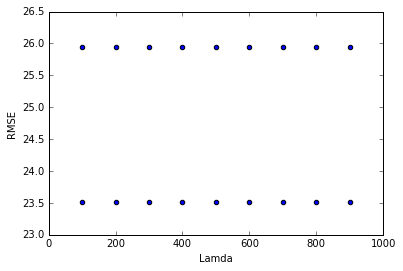

In [73]:
testLamda = []
trainLamda = []

for i in range(100,1000,100):
    a,b = multivariate_ols_ridge(x_train, yvalues=y_train, R=0.000000001, MaxIterations=10000,tol = 0.0001,alpha = 0.0,lamda = i,betas = None)
    
    yHat = a + np.dot(x_train, b)
    yvalue = y_train
    trainLamda.append(sqrt(mean_squared_error(yvalue,yHat)))
    a,b = multivariate_ols_ridge(x_test, yvalues=y_test, R=0.000000001, MaxIterations=10000,tol = 0.0001,alpha = 0.0,lamda = i,betas = None)
    yHat = a + np.dot(x_test, b)
    yvalue = y_test
    testLamda.append(sqrt(mean_squared_error(yvalue,yHat)))
    
plt.scatter(range(100,1000,100), trainLamda)
plt.scatter(range(100,1000,100), testLamda)
plt.xlabel('Lamda')
plt.ylabel('RMSE')

There is still no change in Lamda within each Train, and Test set repectivly. 

### (Showoff) Extra Credit 3: Lambda and coefficients

If you're feeling extra-special, create a parameter plot that shows how the different coefficient estimates change as a function of lambda. To make this graph intelligible, only include the *K* original F_s features in this plot.

In [ ]:
# Your code here

*Discuss your results here*